In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

In [2]:
df = pd.read_csv('../data/merged_data.csv')

In [3]:
# Check the current format of 'event_date'
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

# Verify conversion
print(df['event_date'].head())

# Aggregate data monthly by location and event type
monthly_data = df.groupby(['year_month', 'location', 'event_type']).agg({
    'fatalities': 'sum',
    'rainfall': 'mean',
    'value': 'mean',
    'common_unit_price': 'mean'
}).reset_index()
print()

0   2024-12-31
1   2024-12-31
2   2024-12-30
3   2024-12-30
4   2024-12-28
Name: event_date, dtype: datetime64[ns]



In [4]:
# Market connectivity indicators
df['market_isolation'] = df.groupby('market').size().rank(ascending=False)
df['price_deviation'] = df.groupby(['cpcv2_description', 'year_month'])['value'].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [5]:
# Create severity levels based on fatalities
monthly_data['severity'] = pd.cut(
    monthly_data['fatalities'], 
    bins=[-np.inf, 0, 5, 20, np.inf], 
    labels=['secure', 'stressed', 'crisis', 'emergency'])

# Check the distribution of severity levels
severity_counts = monthly_data['severity'].value_counts()
severity_counts

severity
secure       1377
stressed      160
crisis        158
emergency      30
Name: count, dtype: int64

In [6]:
# Encode severity labels
le = LabelEncoder()
y = le.fit_transform(monthly_data['severity'])

# Select features for classification
X = monthly_data[['fatalities', 'rainfall', 'value', 'common_unit_price']]

# Drop rows with missing values
X = X.dropna()
y = y[X.index]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the shape of the training and testing data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1380, 4), (345, 4), (1380,), (345,))

In [7]:
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Show feature importance
importance_df

,feature,importance
0,fatalities,0.941217
3,common_unit_price,0.028484
2,value,0.021010
1,rainfall,0.009289


In [9]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

      crisis       0.97      1.00      0.99        34
   emergency       1.00      0.75      0.86         4
      secure       1.00      1.00      1.00       275
    stressed       1.00      1.00      1.00        32

    accuracy                           1.00       345
   macro avg       0.99      0.94      0.96       345
weighted avg       1.00      1.00      1.00       345



array([[ 34,   0,   0,   0],
       [  1,   3,   0,   0],
       [  0,   0, 275,   0],
       [  0,   0,   0,  32]])

In [10]:
# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

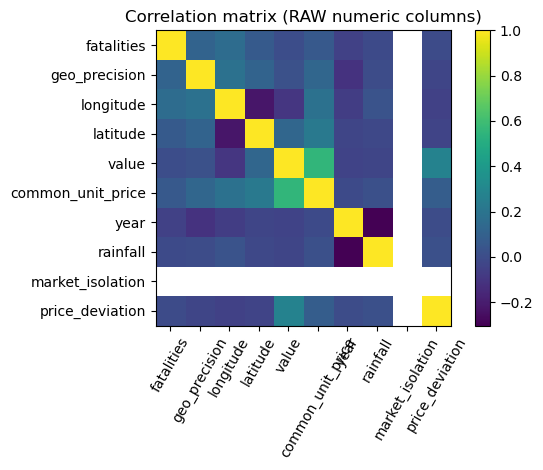

In [11]:
def plot_corr_heatmap_raw(d: pd.DataFrame):
    num_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) < 1:
        print("[skip] correlation heatmap: fewer than 2 numeric columns.")
        return
    corr = d[num_cols].corr()
    plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlation matrix (RAW numeric columns)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=60)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
plot_corr_heatmap_raw(df)

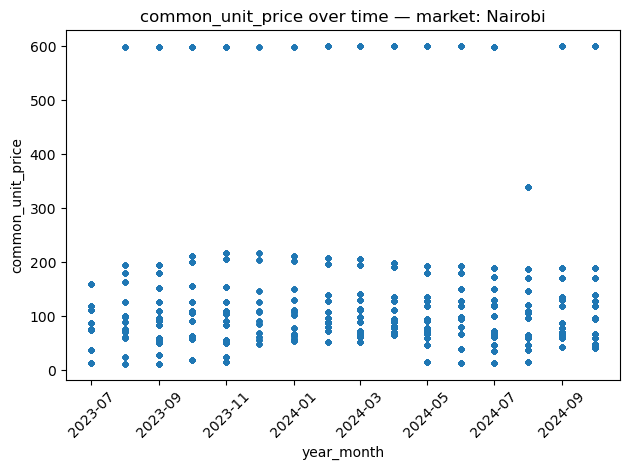

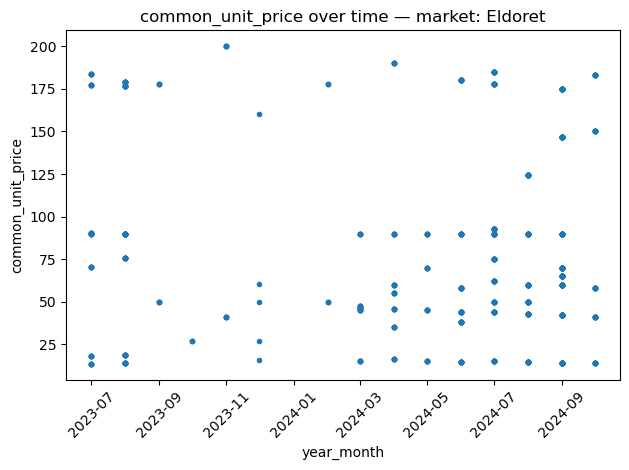

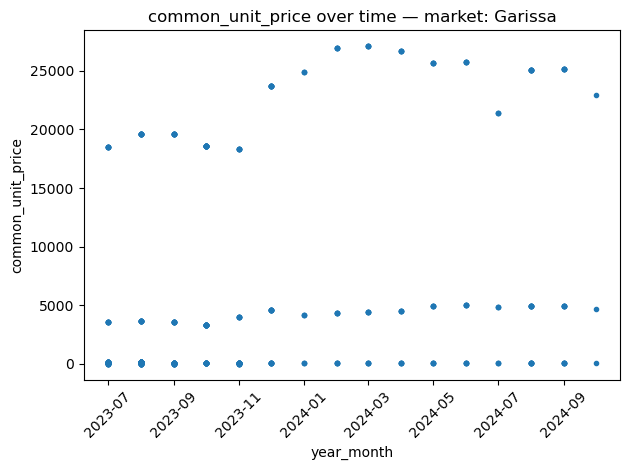

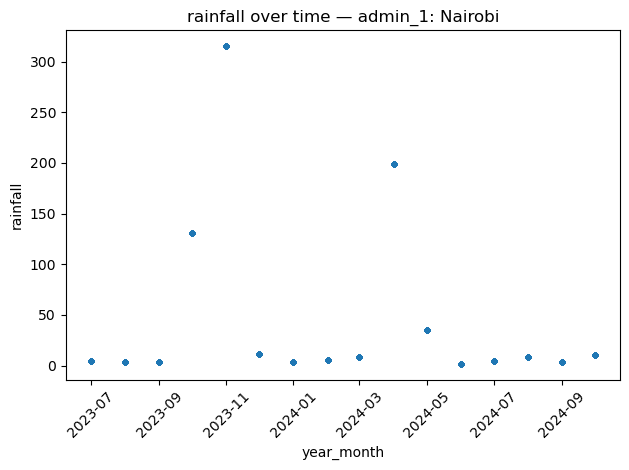

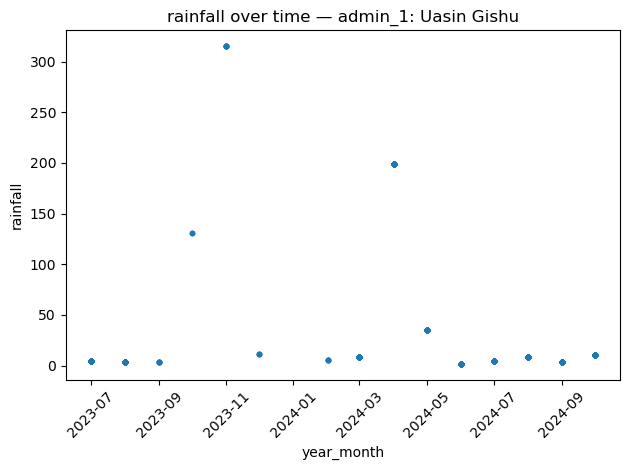

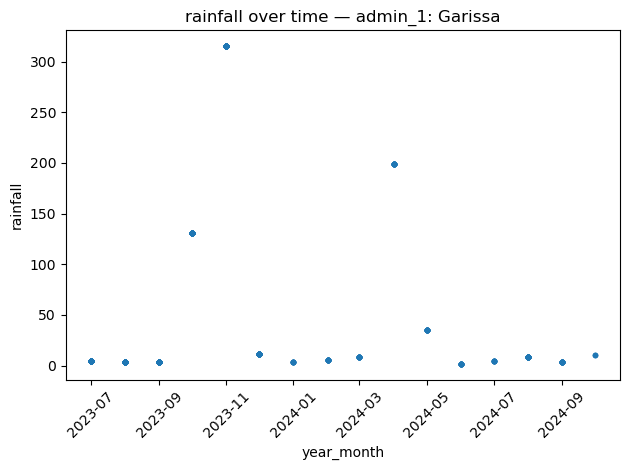

In [10]:
def plot_time_scatter(d: pd.DataFrame, time_col: str, y_col: str, group_col: str, topn_groups: int = 3):
    """Scatter of raw points (no aggregation) for top-N groups by row count."""
    for c in (time_col, y_col, group_col):
        if c not in d.columns:
            print(f"[skip] time scatter: '{c}' not found.")
            return
    top_groups = d[group_col].value_counts().head(topn_groups).index.tolist()
    for g in top_groups:
        sub = d[d[group_col] == g].copy()
        sub[time_col] = pd.to_datetime(sub[time_col], errors="coerce")
        sub[y_col] = pd.to_numeric(sub[y_col], errors="coerce")
        sub = sub.dropna(subset=[time_col, y_col]).sort_values(time_col)
        if sub.empty:
            print(f"[skip] time scatter: no data for {group_col}={g}")
            continue
        plt.figure()
        plt.plot(sub[time_col], sub[y_col], linestyle="", marker="o", markersize=3)
        plt.title(f"{y_col} over time — {group_col}: {g}")
        plt.xlabel(time_col)
        plt.ylabel(y_col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
plot_time_scatter(df, "year_month", "common_unit_price", "market", topn_groups=3)
# Rainfall by admin_1 (top-3)
plot_time_scatter(df, "year_month", "rainfall", "admin_1", topn_groups=3)

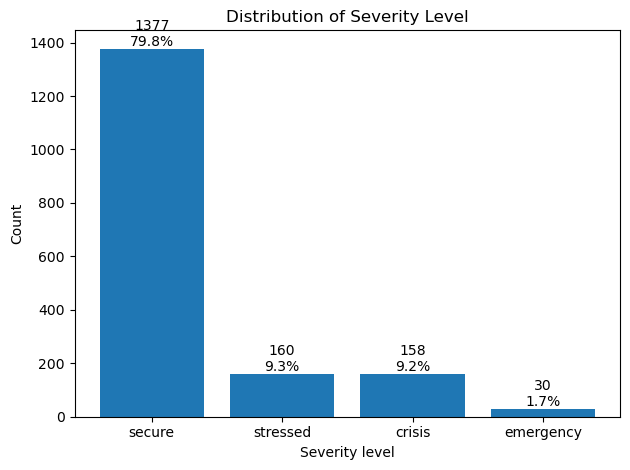

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you haven't already created 'severity', do it (drops NaNs in fatalities safely)
monthly_data = monthly_data.copy()
monthly_data["fatalities"] = pd.to_numeric(monthly_data["fatalities"], errors="coerce")
monthly_data = monthly_data.dropna(subset=["fatalities"])

monthly_data['severity'] = pd.cut(
    monthly_data['fatalities'],
    bins=[-np.inf, 0, 5, 20, np.inf],
    labels=['secure', 'stressed', 'crisis', 'emergency']
)

# Ensure fixed order in the plot
severity_order = pd.CategoricalDtype(
    categories=['secure', 'stressed', 'crisis', 'emergency'],
    ordered=True
)
monthly_data['severity'] = monthly_data['severity'].astype(severity_order)

# Counts (and %)
severity_counts = monthly_data['severity'].value_counts().reindex(severity_order.categories, fill_value=0)
severity_pct = (severity_counts / severity_counts.sum() * 100).round(1)

# --- Plot ---
plt.figure()
bars = plt.bar(severity_counts.index.astype(str), severity_counts.values)
plt.title("Distribution of Severity Level")
plt.xlabel("Severity level")
plt.ylabel("Count")

# Annotate each bar with count and %
for bar, count, pct in zip(bars, severity_counts.values, severity_pct.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{int(count)}\n{pct:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

# 1) Load raw file and build monthly region features
DATA_DIR = Path("../data")        # <- adjust to your layout
merged_path = DATA_DIR / "merged_data.csv"
df_raw = pd.read_csv(merged_path)

df_raw["year_month"] = pd.to_datetime(df_raw["year_month"], errors="coerce").dt.to_period("M").dt.to_timestamp()
if "admin_1" not in df_raw.columns:
    df_raw["admin_1"] = df_raw.get("location", "Unknown")
if "country" not in df_raw.columns:
    df_raw["country"] = "Unknown"

# Prices: staple median (FAO)
if "common_unit_price" in df_raw.columns:
    prices = df_raw[df_raw.get("is_staple_food", True) == True].copy()
    price_m = (prices.dropna(subset=["admin_1","year_month","common_unit_price"])
                     .groupby(["country","admin_1","year_month"], as_index=False)
                     .agg(median_price=("common_unit_price","median"),
                          price_obs=("common_unit_price","size")))
else:
    price_m = pd.DataFrame(columns=["country","admin_1","year_month","median_price","price_obs"])

# Conflict: fatalities sum + event count
conf_df = df_raw.copy()
conf_df["__event"] = 1
conf_m = (conf_df.dropna(subset=["admin_1","year_month"])
                .groupby(["country","admin_1","year_month"], as_index=False)
                .agg(fatalities=("fatalities","sum") if "fatalities" in conf_df.columns else ("__event","sum"),
                     event_count=("__event","sum")))

# Rainfall: mean
if "rainfall" in df_raw.columns:
    rain_m = (df_raw.dropna(subset=["admin_1","year_month","rainfall"])
                .groupby(["country","admin_1","year_month"], as_index=False)
                .agg(rainfall=("rainfall","mean"),
                     rain_obs=("rainfall","size")))
else:
    rain_m = pd.DataFrame(columns=["country","admin_1","year_month","rainfall","rain_obs"])

# Merge all drivers
from functools import reduce
drivers = reduce(
    lambda l, r: pd.merge(l, r, on=["country","admin_1","year_month"], how="outer"),
    [price_m, conf_m, rain_m]
)
drivers = drivers.sort_values(["country","admin_1","year_month"]).reset_index(drop=True)

# -----------------------------
# Derived features
# -----------------------------
# Price momentum
drivers["median_price_pct_change"] = (
    drivers.groupby(["country","admin_1"])["median_price"].pct_change()
)

# FIX: rainfall anomaly with transform (avoids index mismatch from apply)
def _rain_anom(s, window=36, minp=6):
    roll_mean = s.rolling(window, min_periods=minp).mean()
    roll_std  = s.rolling(window, min_periods=minp).std()
    roll_std = roll_std.replace(0, np.nan)   # guard against zero std
    return (s - roll_mean) / roll_std

if "rainfall" in drivers.columns:
    drivers["rainfall_anomaly_z"] = (
        drivers.groupby(["country","admin_1"])["rainfall"]
               .transform(lambda s: _rain_anom(s, window=36, minp=6))
    )

# 2) Proxy label from fatalities (your binning), and t+3 target
drivers["fatalities"] = drivers["fatalities"].fillna(0)
drivers["class_now"] = pd.cut(
    drivers["fatalities"],
    bins=[-np.inf, 0, 5, 20, np.inf],
    labels=["secure","stressed","crisis","emergency"]
).astype(str)

drivers = drivers.sort_values(["admin_1","year_month"]).reset_index(drop=True)
drivers["class_tplus3"] = drivers.groupby("admin_1")["class_now"].shift(-3)

label_map = {"secure":0,"stressed":1,"crisis":2,"emergency":3}
drivers["y_tplus3"] = drivers["class_tplus3"].map(label_map)

# 3) Lags (1..3 months) for features
def add_lags(g, cols, max_lag=3):
    for c in cols:
        for k in range(1, max_lag+1):
            g[f"{c}_lag{k}"] = g[c].shift(k)
    return g

lag_sources = [c for c in [
    "median_price","rainfall","fatalities","event_count",
    "median_price_pct_change","rainfall_anomaly_z"
] if c in drivers.columns]

# keep order stable before groupby-apply
drivers = drivers.sort_values(["admin_1","year_month"]).reset_index(drop=True)
drivers = drivers.groupby("admin_1", group_keys=False).apply(add_lags, cols=lag_sources, max_lag=3)

# 4) Modeling frame + time‑based split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Allow imputer to handle NaNs in features; just ensure target exists
mod = drivers.dropna(subset=["y_tplus3"]).copy()
mod = mod.sort_values(["country","admin_1","year_month"]).reset_index(drop=True)

X_cols = [c for c in mod.columns if any(c.endswith(f"_lag{k}") for k in (1,2,3))]
X = mod[X_cols].values
y = mod["y_tplus3"].values.astype(int)

# Time-based split (80/20)
cutoff = mod["year_month"].quantile(0.8)
train_idx = mod["year_month"] <= cutoff
test_idx  = mod["year_month"] >  cutoff

imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X[train_idx])
X_test  = imp.transform(X[test_idx])

rf = RandomForestClassifier(
    n_estimators=,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y[train_idx])
y_pred = rf.predict(X_test).astype(int)

target_names = ["secure","stressed","crisis","emergency"]
print(pd.DataFrame(
    classification_report(y[test_idx], y_pred, target_names=target_names, output_dict=True)
).T)
print("\nConfusion matrix:\n", confusion_matrix(y[test_idx], y_pred))

# 5) Predictions for dashboard
y_proba = rf.predict_proba(X_test)
pred = mod.loc[test_idx, ["country","admin_1","year_month"]].copy()
pred["pred_class_tplus3"] = [target_names[i] for i in y_pred]
pred["prob_crisis_or_worse"] = y_proba[:, 2] + y_proba[:, 3]

pred.to_csv("../data/predictions.csv", index=False)
print("\nWrote predictions to ../data/predictions.csv")

pred

/tmp/ipykernel_6163/1180439654.py:56: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  drivers.groupby(["country","admin_1"])["median_price"].pct_change()
/tmp/ipykernel_6163/1180439654.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drivers = drivers.groupby("admin_1", group_keys=False).apply(add_lags, cols=lag_sources, max_lag=3)


              precision    recall  f1-score  support
secure         0.571429  0.909091  0.701754     22.0
stressed       0.250000  0.250000  0.250000      8.0
crisis         0.250000  0.090909  0.133333     11.0
emergency      1.000000  0.142857  0.250000      7.0
accuracy       0.500000  0.500000  0.500000      0.5
macro avg      0.517857  0.348214  0.333772     48.0
weighted avg   0.506696  0.500000  0.430318     48.0

Confusion matrix:
 [[20  1  1  0]
 [ 6  2  0  0]
 [ 6  4  1  0]
 [ 3  1  2  1]]

Wrote predictions to ../data/predictions.csv


,country,admin_1,year_month,pred_class_tplus3,prob_crisis_or_worse
13,Kenya,Embu,2024-06-01,secure,0.500000
14,Kenya,Embu,2024-07-01,secure,0.250000
26,Kenya,Garissa,2024-06-01,stressed,0.250000
27,Kenya,Garissa,2024-07-01,crisis,0.750000
38,Kenya,Isiolo,2024-06-01,secure,0.500000
39,Kenya,Isiolo,2024-07-01,secure,0.500000
50,Kenya,Kajiado,2024-06-01,secure,0.500000
51,Kenya,Kajiado,2024-07-01,secure,0.250000
63,Kenya,Kiambu,2024-06-01,stressed,0.250000
64,Kenya,Kiambu,2024-07-01,stressed,0.250000


In [15]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 13 to 278
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   country               48 non-null     object        
 1   admin_1               48 non-null     object        
 2   year_month            48 non-null     datetime64[ns]
 3   pred_class_tplus3     48 non-null     object        
 4   prob_crisis_or_worse  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.2+ KB
